# =================================
#               Predictive Maintenance(SECOM)
#           Author: Agrita Vatish, Deepak Burathoki
# =================================


# =====================
# 1️ - Imports & Load dataset
# =====================

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pre Processing tools imports
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit

# ML Models imports
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Deep learning imports
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization

# ARIMA imports
from statsmodels.tsa.arima.model import ARIMA

# Performance Evaluation imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Ignore all the warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_file = "secom.data"
label_file = "secom_labels.data"

feature_names = [f"f{i}" for i in range(1, 591)]
df_data = pd.read_csv(data_file, sep=" ", names=feature_names, na_values="NaN", engine="python")
df_labels = pd.read_csv(label_file, sep=" ", names=["label", "date"], parse_dates=["date"], na_values="NaN", dayfirst=True)

df = pd.concat([df_data, df_labels], axis=1)

# =====================
# 2- Exploratory Data Analysis
# =====================

## 2.1 - Basic Information About Data
##

### 2.1.1 - Top 6 Records

In [8]:
df.head(6).T

,0,1,2,3,4,5
f1,3030.93,3095.78,2932.61,2988.72,3032.24,2946.25
f2,2564.0,2465.14,2559.94,2479.9,2502.87,2432.84
f3,2187.7333,2230.4222,2186.4111,2199.0333,2233.3667,2233.3667
f4,1411.1265,1463.6606,1698.0172,909.7926,1326.52,1326.52
f5,1.3602,0.8294,1.5102,1.3204,1.5334,1.5334
...,...,...,...,...,...,...
f588,NaN,0.0201,0.0484,0.0149,0.0149,0.0151
f589,NaN,0.006,0.0148,0.0044,0.0044,0.0052
f590,NaN,208.2045,82.8602,73.8432,73.8432,44.0077
label,-1,-1,1,-1,-1,-1


### 2.1.2 - Statistical Summary

In [10]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
f1,1561.0,3014.452896,2743.24,2966.26,3011.49,3056.65,3356.35,73.621787
f2,1560.0,2495.850231,2158.75,2452.2475,2499.405,2538.8225,2846.44,80.407705
f3,1553.0,2200.547318,2060.66,2181.0444,2201.0667,2218.0555,2315.2667,29.513152
f4,1553.0,1396.376627,0.0,1081.8758,1285.2144,1591.2235,3715.0417,441.69164
f5,1553.0,4.197013,0.6815,1.0177,1.3168,1.5257,1114.5366,56.35554
...,...,...,...,...,...,...,...,...
f588,1566.0,0.016475,0.0032,0.0106,0.0148,0.0203,0.0799,0.008808
f589,1566.0,0.005283,0.001,0.0033,0.0046,0.0064,0.0286,0.002867
f590,1566.0,99.670066,0.0,44.3686,71.9005,114.7497,737.3048,93.891919
label,1567.0,-0.867262,-1.0,-1.0,-1.0,-1.0,1.0,0.49801


### 2.1.3 -  Checking Missing Values

In [12]:
df.isna().sum()

f1        6
f2        7
f3       14
f4       14
f5       14
         ..
f588      1
f589      1
f590      1
label     0
date      0
Length: 592, dtype: int64

## 2.2 - Features Distribution and Co-Relation
##

### 2.2.1 - Checking Label Categories & Distribution

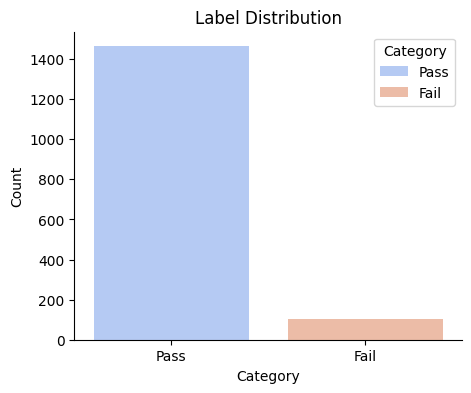

In [15]:
plt.figure(figsize=(5, 4))
sns.countplot(
    x=df["label"].replace({-1: "Pass", 1: "Fail"}),
    hue=df["label"].replace({-1: "Pass", 1: "Fail"}),
    palette="coolwarm",
    legend=False
)
plt.title("Label Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.legend(title="Category", labels=["Pass", "Fail"])
sns.despine()
plt.show()


### 2.2.2 - Checking Feature Distribution (6 Random Features)

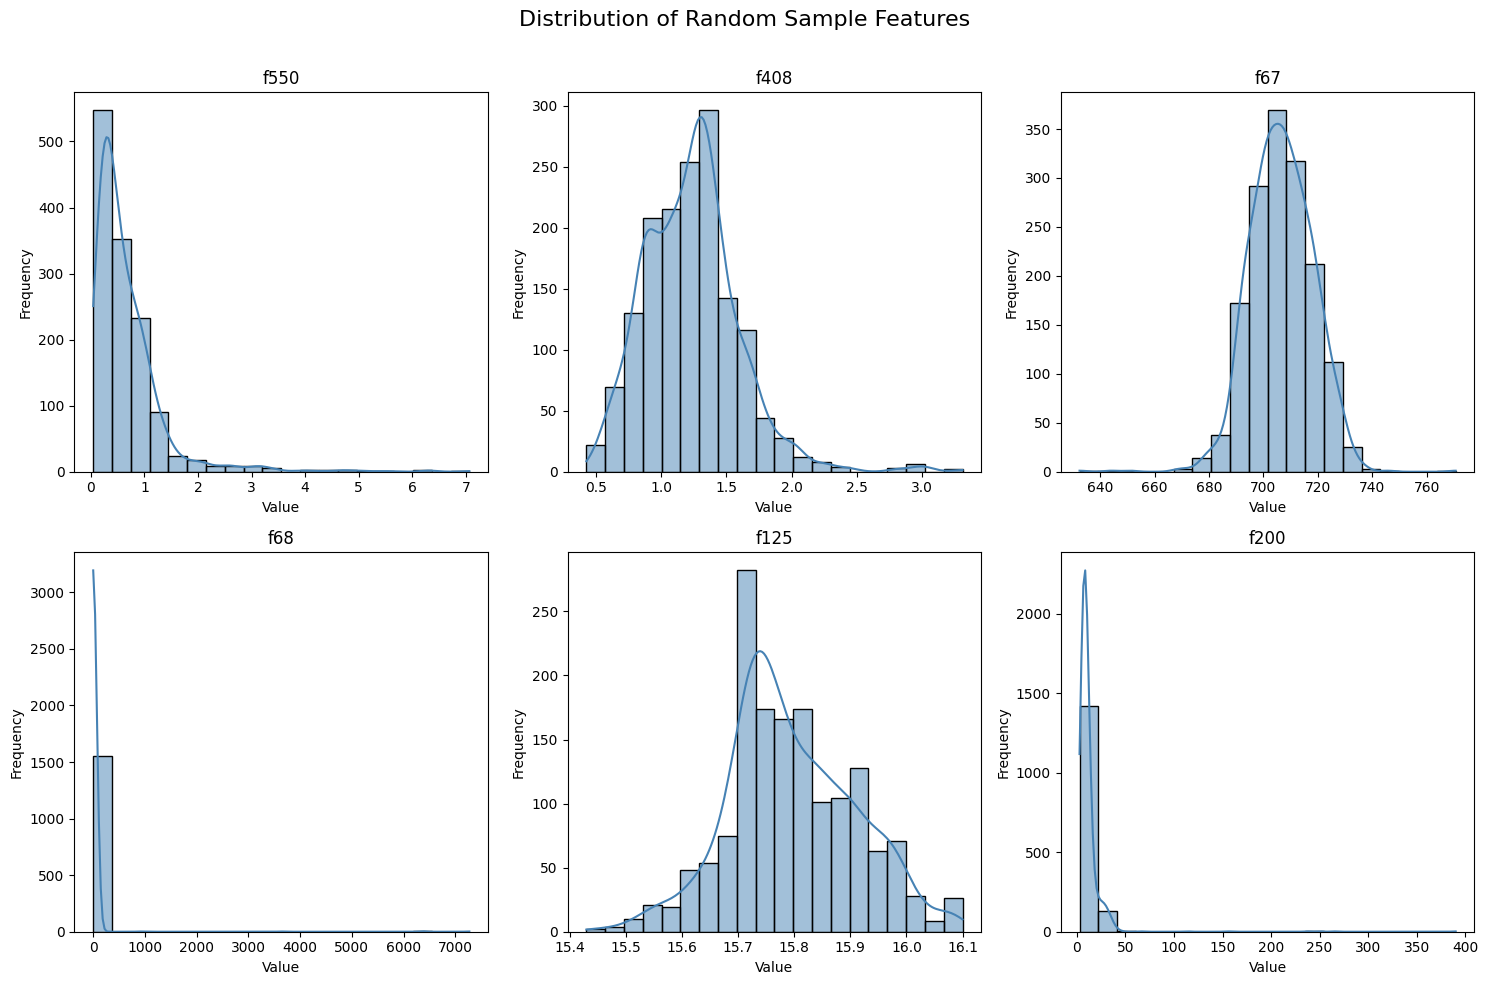

In [17]:
# Randomly pick 6 feature columns
sample_features = np.random.choice([f"f{i}" for i in range(1, 591)], 6, replace=False)

# Create a 2x3 grid for the 6 features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Distribution of Random Sample Features", fontsize=16)

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot each feature using seaborn.histplot
for i, feature in enumerate(sample_features):
    sns.histplot(df[feature], bins=20, kde=True, color="steelblue", ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Hide any unused subplots (in case of odd number)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


### 2.2.3 - Co-Relation Heatmap of First 30 Features

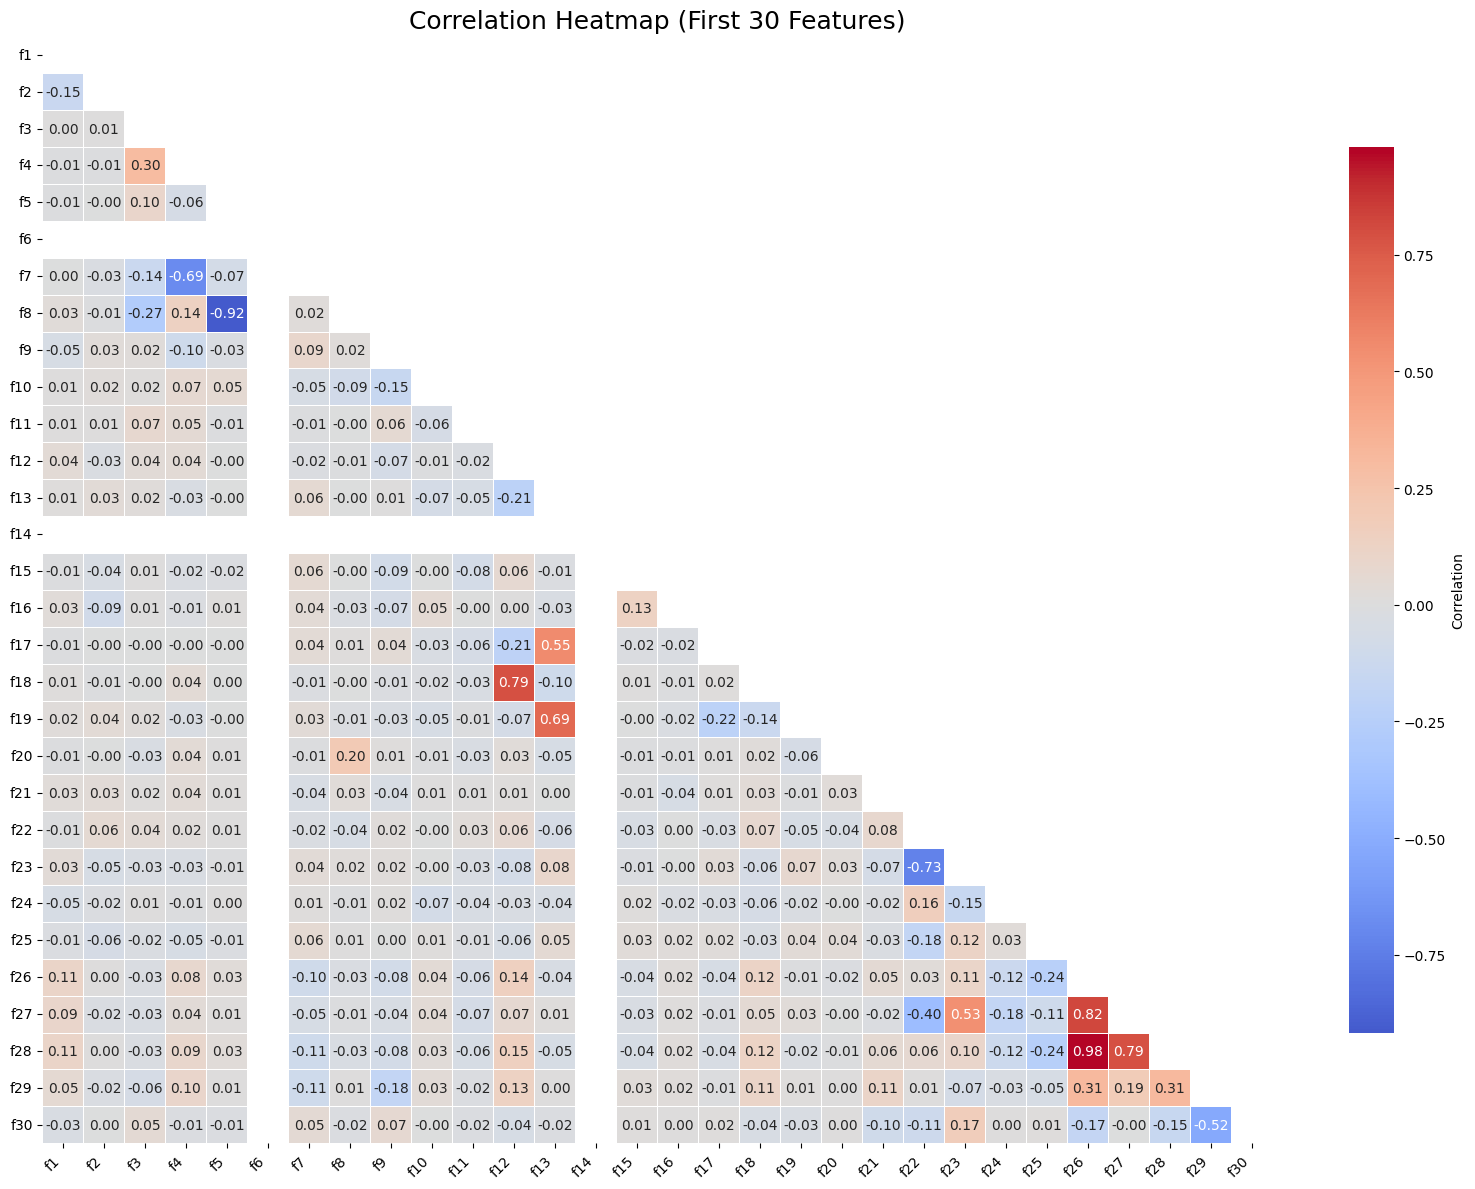

In [19]:
# Select first 30 features
corr_features = [f"f{i}" for i in range(1, 31)]
corr_matrix = df[corr_features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",        # Diverging color map for positive/negative correlation
    annot=True,             # Show correlation values
    fmt=".2f",              # Format decimals
    linewidths=0.5,         # Lines between cells
    cbar_kws={"shrink": 0.8, "label": "Correlation"},  # Colorbar settings
    center=0
)
plt.title("Correlation Heatmap (First 30 Features)", fontsize=18)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### 2.2.4 - Top 10 Features Most Correlated Features (X) with Label (y)

No. of Constant columns: 116


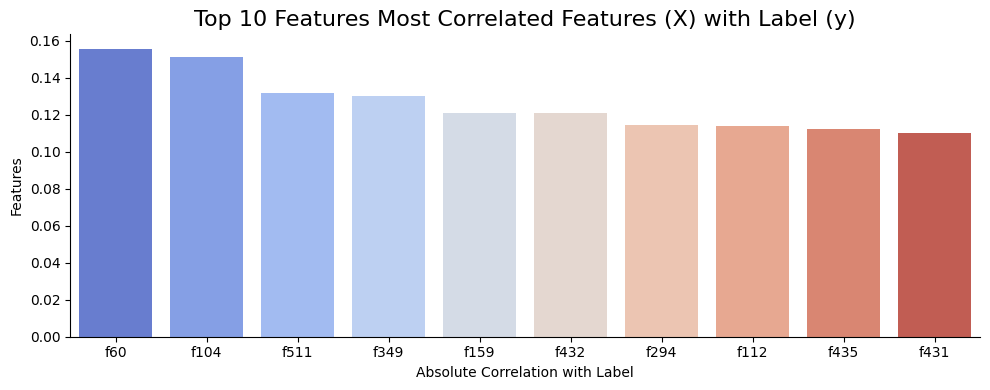

In [21]:
df2 = df.copy()

# Checking Constant Columns
constant_cols = df2.drop(columns=['label', 'date']).columns[df2.drop(columns=['label', 'date']).nunique() <= 1]
print("No. of Constant columns:", len(constant_cols))

# Dropping Constant Columns before co-relation
df_corr = df.drop(columns=list(constant_cols) + ['label', 'date'])
corr = df_corr.corrwith(df["label"]).abs().sort_values(ascending=False)
top_corr_features = corr.head(10)

# Plot
plt.figure(figsize=(10,4))
sns.barplot(y=top_corr_features.values, x=top_corr_features.index, palette="coolwarm", hue = top_corr_features.index)
plt.title("Top 10 Features Most Correlated Features (X) with Label (y)", fontsize=16)
plt.xlabel("Absolute Correlation with Label")
plt.ylabel("Features")
plt.tight_layout()
sns.despine()
plt.show()



## 2.3 - Time Series Analysis
##

In [23]:
df2 = df.copy()
# Ensure the 'date' column is in datetime format and sorted
df2["date"] = pd.to_datetime(df["date"], errors='coerce')
df2 = df2.sort_values(by="date")


### 2.3.1 - Failure Trends Over Time

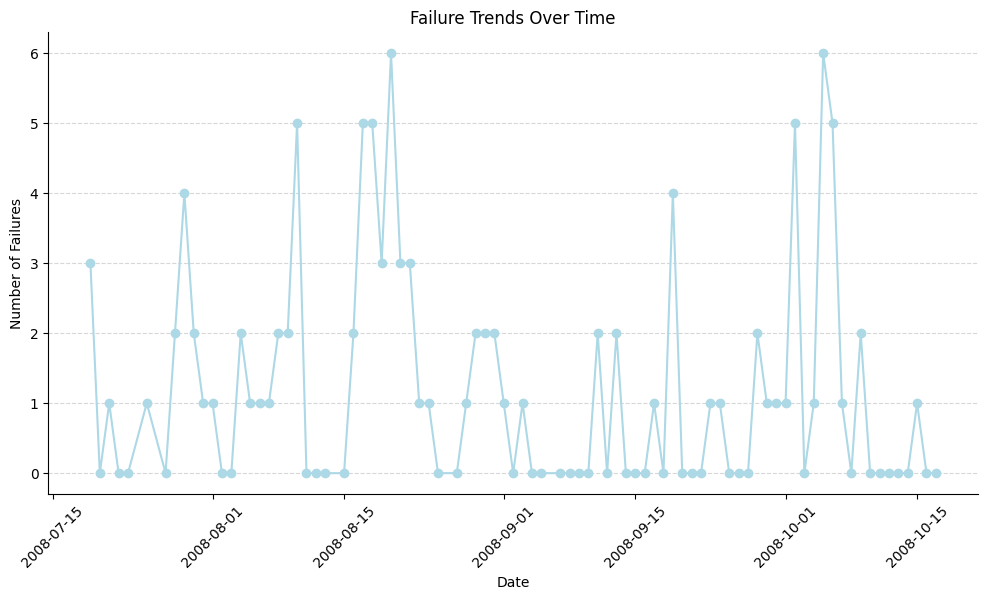

In [25]:
plt.figure(figsize=(12,6))
failure_trend = df2.groupby(df2["date"].dt.date)["label"].apply(lambda x: (x == 1).sum())

failure_trend.plot(kind='line', marker='o', color='lightblue')
plt.title("Failure Trends Over Time")

plt.xlabel("Date")
plt.ylabel("Number of Failures")

# plt.grid(True)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
sns.despine()
plt.show()

### 2.3.2 - Rolling Average of Failures (7-day)

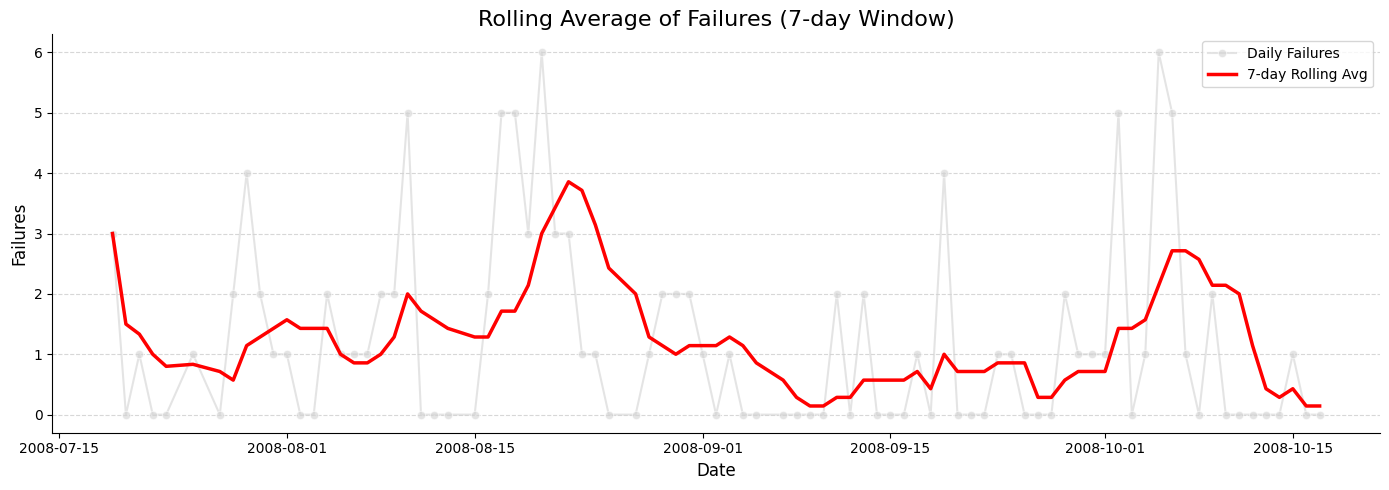

In [27]:
# Prepare data
rolling_fail = failure_trend.rolling(window=7, min_periods=1).mean()
plot_data = failure_trend.reset_index()
plot_data.rename(columns={"label": "failures", "index": "date"}, inplace=True)
plot_data["rolling_avg"] = rolling_fail.values

plt.figure(figsize=(14,5))

# Daily failures (scatter/line)
sns.lineplot(
    data=plot_data,
    x="date",
    y="failures",
    marker="o",
    color="lightgray",
    label="Daily Failures",
    alpha=0.6
)

# 7-day rolling average (smooth line)
sns.lineplot(
    data=plot_data,
    x="date",
    y="rolling_avg",
    color="red",
    linewidth=2.5,
    label="7-day Rolling Avg"
)

plt.title("Rolling Average of Failures (7-day Window)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Failures", fontsize=12)
# plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
sns.despine()
plt.legend()
plt.tight_layout()
plt.show()


### 2.3.3 - Failure VS Pass Count

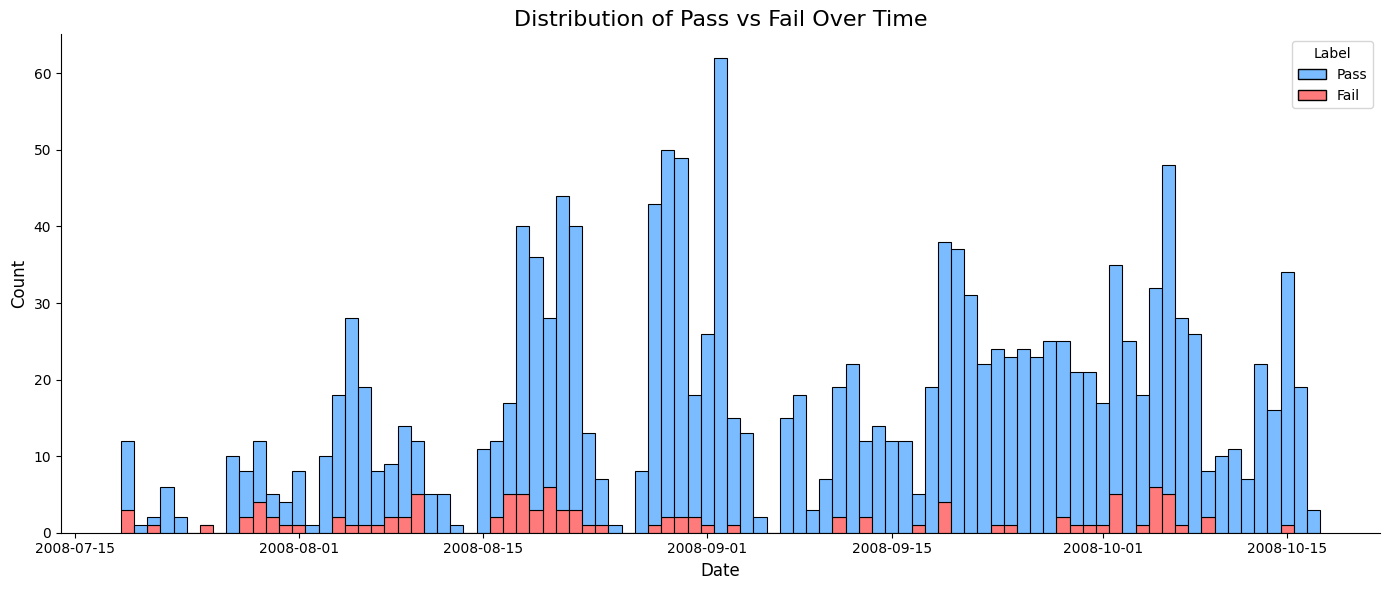

In [29]:
# Prepare the data in long format
label_counts = df2.groupby(df2["date"].dt.date)["label"].value_counts().unstack().fillna(0)
label_counts.columns = ["Fail" if col == 1 else "Pass" for col in label_counts.columns]
label_counts = label_counts.reset_index().melt(id_vars="date", value_vars=["Pass", "Fail"], var_name="Label", value_name="Count")

plt.figure(figsize=(14,6))
sns.histplot(
    data=label_counts,
    x="date",
    weights="Count",        # Use counts as weights
    hue="Label",
    multiple="stack",       # Stack Pass and Fail
    palette={"Pass": "#4da6ff", "Fail": "#ff4d4d"},
    bins=len(label_counts["date"].unique())  # one bin per date
)
plt.title("Distribution of Pass vs Fail Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
sns.despine()
plt.show()


### 2.3.4 - Failure Rate Percentage

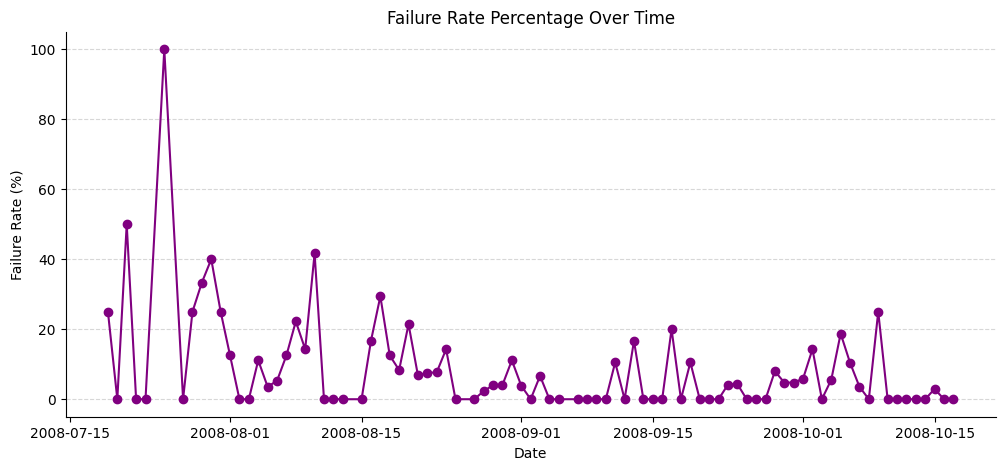

In [31]:
fail_rate = (failure_trend / df.groupby(df["date"].dt.date)["label"].count()) * 100

plt.figure(figsize=(12,5))
fail_rate.plot(marker='o', color='purple')
plt.title("Failure Rate Percentage Over Time")
plt.xlabel("Date")
plt.ylabel("Failure Rate (%)")
# plt.grid(True)
plt.grid(axis="y", linestyle="--", alpha=0.5)
sns.despine()
plt.show()

# =====================
# 3 - DATA PRE PROCESSING
# =====================

In [12]:
data_file = "secom.data"
label_file = "secom_labels.data"

feature_names = [f"f{i}" for i in range(1, 591)]
df_data = pd.read_csv(data_file, sep=" ", names=feature_names, na_values="NaN", engine="python")
df_labels = pd.read_csv(label_file, sep=" ", names=["label", "date"], parse_dates=["date"], na_values="NaN", dayfirst=True)
df = pd.concat([df_data, df_labels], axis=1)


# ===============================================
# 3.1 Date Handling and Sorting
# ===============================================

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df['label'] = df['label'].replace({-1: 0, 1: 1})

# ==============================================================
# 3.2 - Imputing Missing Values and Creating Features and target
# ==============================================================

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(df.drop(columns=['label', 'date'])), columns=df.drop(columns=['label', 'date']).columns)
y = df['label']

# ===============================================
# 3.3 SMOTE for class balancing (ML models)
# ===============================================

smote = SMOTE(random_state=42, sampling_strategy='auto')
X, y = smote.fit_resample(X, y)

# ===============================================
# 3.4 Scaling
# ===============================================

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# ===============================================
# 3.5 Train-test split
# ===============================================
# Time-based split: e.g., 80% train, 20% test
split_index = int(len(df) * 0.8)

X_train = X_scaled.iloc[:split_index, :]
y_train = y.iloc[:split_index]
X_test = X_scaled.iloc[split_index:, :]
y_test = y.iloc[split_index:]


# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
print(y_train.value_counts())

print(y_test.value_counts())

label
0    1166
1      87
Name: count, dtype: int64
label
1    1376
0     297
Name: count, dtype: int64


# =====================
# 4 -  Traditional ML models
# =====================

## 4.1 - Model Training & Performance Evaluation

In [18]:
results = []

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM (RBF)": SVC(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
        
    results.append([name, acc, prec, rec, f1])
    # print(f"{name} \n {classification_report(y_test, y_pred)} \n\n")


# =====================
# 5 - LSTM Model
# =====================

## 5.1 - Sequencial Data Prepreration for LSTM

In [22]:
# Prepare sequences for LSTM
timesteps = 10 # past 10 runs as input
X_seq, y_seq = [], []

for i in range(len(X_scaled) - timesteps):
    X_seq.append(X_scaled.iloc[i:i+timesteps].values)
    y_seq.append(y.iloc[i+timesteps])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Train-test split
split_point = int(len(X_seq) * 0.8)

X_train_seq, X_test_seq = X_seq[:split_point], X_seq[split_point:]
y_train_seq, y_test_seq = y_seq[:split_point], y_seq[split_point:]

In [24]:
# # Time Based split

# split_point = int(0.8 * len(X_seq))

# # Move backward until test set has both classes (conuter the class imbalance)
# while len(np.unique(y_seq[split_point:])) < 2:
#     split_point -= 1

# X_train_seq, X_test_seq = X_seq[:split_point], X_seq[split_point:]
# y_train_seq, y_test_seq = y_seq[:split_point], y_seq[split_point:]


## 5.2 - SMOTE for class Balancing in LSTM

In [27]:
# # # # --------- For Train Data -------------

# # Shape info
# n_samples, timesteps, n_features = X_train_seq.shape

# # Flatten sequences for SMOTE (samples, timesteps*features)
# X_train_flat = X_train_seq.reshape(n_samples, timesteps * n_features)

# # Apply SMOTE only on training sequences
# smote = SMOTE(random_state=42, sampling_strategy=0.7)
# X_train_seq, y_train_seq = smote.fit_resample(X_train_flat, y_train_seq)

# # Reshape back to 3D sequences
# X_train_seq = X_train_seq.reshape(-1, timesteps, n_features)

# # # --------- For Test Data -------------

# # Shape info
# n_samples, timesteps, n_features = X_test_seq.shape

# # Flatten sequences for SMOTE (samples, timesteps*features)
# X_test_flat = X_test_seq.reshape(n_samples, timesteps * n_features)

# # Apply SMOTE only on test sequences
# # smote2 = SMOTE(random_state=42, sampling_strategy=0.5)
# X_test_seq, y_test_seq = smote.fit_resample(X_test_flat, y_test_seq)

# # Reshape back to 3D sequences
# X_test_seq = X_test_seq.reshape(-1, timesteps, n_features)


In [29]:
# print("Train shape AFTER SMOTE :", X_train_seq.shape, "Test shape AFTER SMOTE :", X_test_seq.shape)
# print("Train class distribution  AFTER SMOTE:", np.bincount(y_train_seq))
# print("Test class distribution AFTER SMOTE :", np.bincount(y_test_seq))

## 5.3 - Model Creation and Training

In [32]:
# # Model Instance
# lstm_model = Sequential()

# # Input layer
# lstm_model.add(Input(shape=(timesteps, X_train_seq.shape[2])))

# # # First LSTM layer
# # lstm_model.add(LSTM(128, return_sequences=True))
# # lstm_model.add(Dropout(0.3))
# # lstm_model.add(BatchNormalization())

# # Second LSTM layer
# lstm_model.add(LSTM(64))
# lstm_model.add(Dropout(0.2))
# lstm_model.add(BatchNormalization())


# # # Third LSTM layer
# # lstm_model.add(LSTM(32))
# # lstm_model.add(Dropout(0.3))
# # lstm_model.add(BatchNormalization())

# lstm_model.add(Dense(32, activation='relu'))

# # Output layer
# lstm_model.add(Dense(1, activation='sigmoid'))



# Model Architecture

lstm_model = Sequential([
    Input(shape=(timesteps, X_train_seq.shape[2])),
    
    LSTM(64, return_sequences=False),  # just one layer
    Dropout(0.4),
    BatchNormalization(),
    
    Dense(32, activation='relu'),
    
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])


# Model Compile
# lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])


# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Computing Class weights for Imbalance 
cw = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_seq)
class_weights = dict(enumerate(cw))

# Model Trainig
history = lstm_model.fit(X_train_seq, y_train_seq, validation_split = 0.2, epochs=20, batch_size=16, class_weight=class_weights, callbacks=[early_stop])

Epoch 1/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5996 - loss: 0.6337 - val_accuracy: 0.9529 - val_loss: 0.4290
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8658 - loss: 0.3240 - val_accuracy: 0.9936 - val_loss: 0.1598
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9296 - loss: 0.2414 - val_accuracy: 0.9979 - val_loss: 0.0728
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9385 - loss: 0.2122 - val_accuracy: 0.9957 - val_loss: 0.0550
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9456 - loss: 0.1866 - val_accuracy: 0.9979 - val_loss: 0.0374
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9356 - loss: 0.1755 - val_accuracy: 0.9979 - val_loss: 0.0357
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9430 - loss: 0.1640 - val_accuracy: 0.9979 - val_loss: 0.0481
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9565 - loss: 0.1417 - val_accuracy: 0

## 5.4 - Performance Evaluation

### 5.4.1 - LSTM Model Generalization Plot

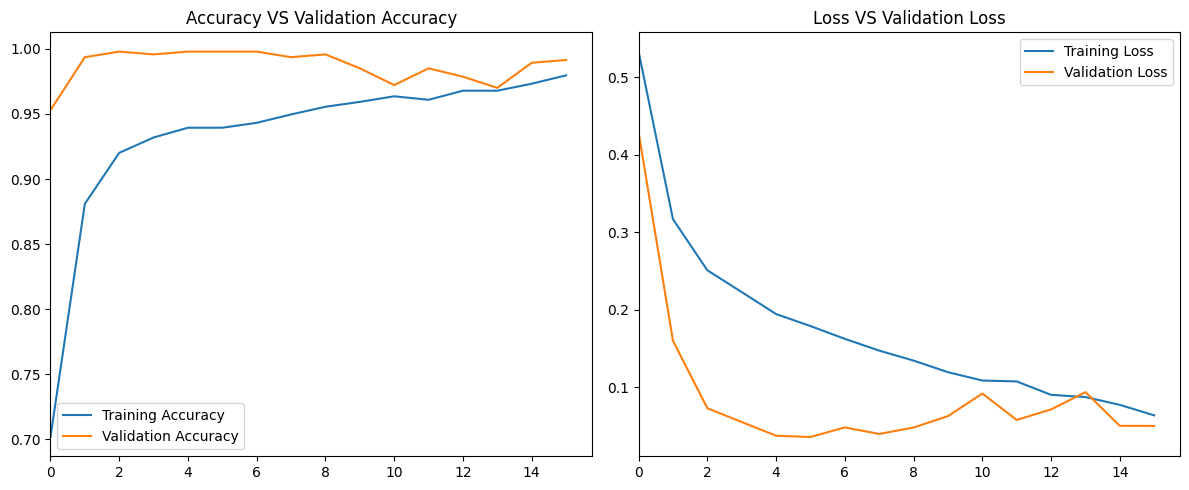

In [35]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.xlim(left=0)
plt.title('Accuracy VS Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlim(left=0)
plt.legend()
plt.title('Loss VS Validation Loss')

plt.tight_layout()
plt.show()


### 5.4.1 - Test Data Results

In [37]:
# Predict probabilities from LSTM
y_prob_lstm = lstm_model.predict(X_test_seq)

# Convert probabilities to binary labels using np.where
y_pred_lstm = np.where(y_prob_lstm > 0.5, 1, 0)

# Metrics
acc = accuracy_score(y_test_seq, y_pred_lstm)
prec = precision_score(y_test_seq, y_pred_lstm)
rec = recall_score(y_test_seq, y_pred_lstm)
f1 = f1_score(y_test_seq, y_pred_lstm)

results.append(["LSTM", acc, prec, rec, f1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


# =====================
# 6 - ARIMA Forecasting
# =====================

### 6.1 - Next 5 Forcasted Failure

In [54]:
# Aggregate failures per day
df['date_only'] = df['date'].dt.date
failures_per_day = df.groupby('date_only')['label'].sum()

# Fit ARIMA (example order (1,1,1))
arima_model = ARIMA(failures_per_day, order=(1,1,1))
arima_fit = arima_model.fit()
forecast = arima_fit.forecast(steps=5)
print("\nARIMA Forecast (next 5 runs of failures):")
print(forecast)


ARIMA Forecast (next 5 runs of failures):
86    0.746572
87    1.033817
88    1.144336
89    1.186858
90    1.203219
Name: predicted_mean, dtype: float64


### 6.2 - Next 5 Runs of Failure Plot

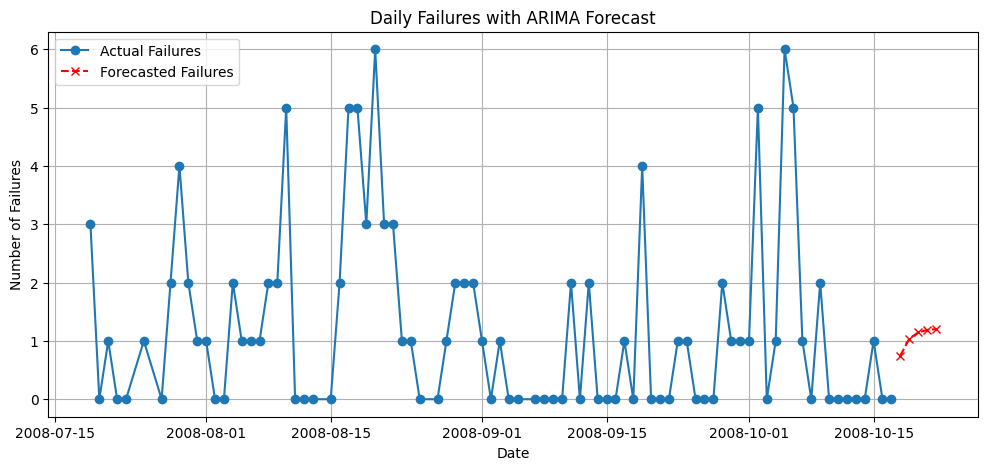

In [56]:
# Historical failures
history_dates = failures_per_day.index
history_values = failures_per_day.values

# Forecasted failures
forecast_values = forecast.values
forecast_dates = pd.date_range(start=history_dates[-1] + pd.Timedelta(days=1), periods=len(forecast_values))

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Plot actual failures
plt.plot(history_dates, history_values, label='Actual Failures', marker='o')

# Plot forecasted failures
plt.plot(forecast_dates, forecast_values, label='Forecasted Failures', marker='x', linestyle='--', color='red')

plt.title("Daily Failures with ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Failures")
plt.legend()
plt.grid(True)
plt.show()


# =====================
# 7 - Results table and plot
# =====================

## 7.1 - Test Data Results (Table and PLot)

### 7.2.1 - Tabular Comparison

In [60]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\nModel Performance Comparison:")
results_df


Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.948805,0.907121,1.000000,0.951299
1,Random Forest,0.984642,0.989655,0.979522,0.984563
2,SVM (RBF),0.991468,0.983221,1.000000,0.991540
3,XGBoost,0.986348,0.983051,0.989761,0.986395
4,LSTM,0.998288,1.000000,0.998288,0.999143


### 7.2.2 - Visual Comparison

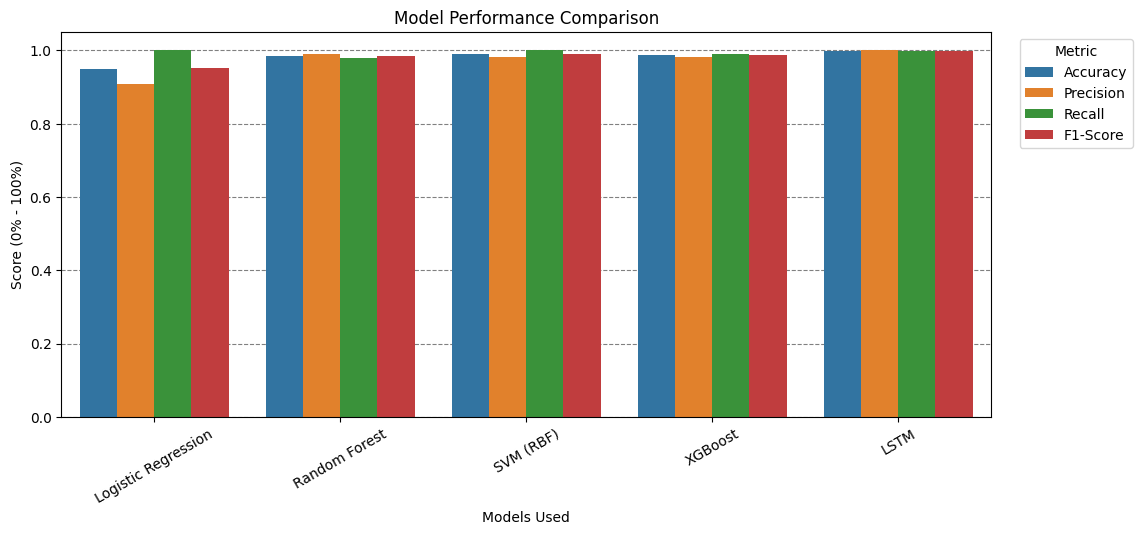

In [62]:
# Bar plot
plt.figure(figsize=(12,5))

# Create Seaborn barplot
ax = sns.barplot(
    data=results_df.melt(id_vars="Model", value_vars=["Accuracy","Precision","Recall","F1-Score"]),
    x="Model", y="value", hue="variable"
)

# Set grid behind bars
ax.set_axisbelow(True)  # ensures grid is behind bars
plt.grid(True, axis='y', linestyle='--', color='gray', zorder=0)

# Title and labels
plt.title("Model Performance Comparison")
plt.xlabel("Models Used")
plt.ylabel("Score (0% - 100%)")
plt.xticks(rotation=30)

# Legend outside
plt.legend(title="Metric", loc='upper right', bbox_to_anchor=(1.16, 1))

plt.show()